# Jane Street - PLS XGB

In [1]:
# use the older xgboost
!pip uninstall xgboost -y
!pip install xgboost==1.2.1

import joblib
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

In [2]:
# read data as 32 bit floats
file = os.path.join(os.pardir, "input", "jane-street-market-prediction", "train.csv")
dtype = {c: np.float32 for c in pd.read_csv(file, nrows=1).columns}
full_df = pd.read_csv(file, engine="c", dtype=dtype)

# split into training and validation
train_df = full_df[full_df["date"].between(0, 400)]
valid_df = full_df[full_df["date"].between(425, 500)]

# build features and labels
features = [f"feature_{x}" for x in range(130)]
train_X = train_df[features].to_numpy()
valid_X = valid_df[features].to_numpy()
train_y = train_df["resp"].gt(0.0).astype(np.uint8).to_numpy()
valid_y = valid_df["resp"].gt(0.0).astype(np.uint8).to_numpy()

In [3]:
# impute and normalize data
si = SimpleImputer(strategy="mean")
ss = StandardScaler()

train_X = si.fit_transform(train_X)
train_X = ss.fit_transform(train_X)

valid_X = si.transform(valid_X)
valid_X = ss.transform(valid_X)

# compute R2 scores of PLS model for different
# number of PLS components
#train_scores = np.empty(130)
#valid_scores = np.empty(130)
#components = np.arange(1, 131)
#for ix, comp in enumerate(components):
#    pls = PLSRegression(n_components=comp)
#    pls.fit(train_X, train_df["resp"].to_numpy())
#    train_scores[ix] = pls.score(train_X, train_df["resp"])
#    valid_scores[ix] = pls.score(valid_X, valid_df["resp"])

# plot the scores
#plt.figure(figsize=(8, 5))
#sns.lineplot(x=components, y=train_scores, label="Training")
#sns.lineplot(x=components, y=valid_scores, label="Validation")
#plt.xlabel("Components")    
#plt.ylabel("Score")
#plt.grid(True)
#plt.show()

# refit the model on the number of components just
# on the top of the plateau and transform the data
pls = PLSRegression(n_components=40)
pls.fit(train_X, train_df["resp"].to_numpy())

train_X = pls.transform(train_X)
valid_X = pls.transform(valid_X)

# save preprocessing pipeline
pp = make_pipeline(si, ss, pls)

In [4]:
# successive sets of parameters tried
params = {"max_depth": list(range(3, 10)),
          "min_child_weight": list(range(1, 6))
         }

params = {"max_depth": [7],
          "min_child_weight": [2],
          "gamma": [x * 1e-5 for x in range(10)]
         }

params = {"max_depth": [7],
          "min_child_weight": [2],
          "gamma": [0],
          "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
         }

params = {"max_depth": [7],
          "min_child_weight": [2],
          "gamma": [0],
          "subsample": [1.0],
          "colsample_bytree": [1.0],
          "reg_alpha": [130, 140, 150, 160, 170, 180, 190, 200],
          "reg_lambda": [0.7, 0.8, 0.9]
         }

params = {"max_depth": [7],
          "min_child_weight": [2],
          "gamma": [0],
          "subsample": [1.0],
          "colsample_bytree": [1.0],
          "reg_alpha": [140],
          "reg_lambda": [0.8],
          "learning_rate": [x * 0.05 for x in range(1, 11)]
         }

params = {"max_depth": [6, 7, 8],
          "min_child_weight": [2],
          "gamma": [0],
          "subsample": [0.8, 0.9, 1.0],
          "colsample_bytree": [0.8, 0.9, 1.0],
          "reg_alpha": [120, 140, 160],
          "reg_lambda": [0.7, 0.8, 0.9],
          "learning_rate": [0.025, 0.05, 0.075]
         }

params = {"max_depth": [8, 9],
          "min_child_weight": [2],
          "gamma": [0],
          "subsample": [0.8, 0.9, 1.0],
          "colsample_bytree": [0.9, 1.0],
          "reg_alpha": [100, 120, 140],
          "reg_lambda": [0.7, 0.8, 0.9],
          "learning_rate": [0.02, 0.025, 0.03]
         }

params = {"max_depth": [8],
          "min_child_weight": [2],
          "gamma": [0],
          "subsample": [0.6, 0.7, 0.8],
          "colsample_bytree": [1.0],
          "reg_alpha": [80, 90, 100, 110],
          "reg_lambda": [0.8, 0.9, 1, 2],
          "learning_rate": [0.025]
         }

params = {"max_depth": [8],
          "min_child_weight": [2],
          "gamma": [0],
          "subsample": [0.8],
          "colsample_bytree": [1.0],
          "reg_alpha": [100],
          "reg_lambda": [0.9],
          "learning_rate": [0.025]
         }


# early stopping
fit_params = {"early_stopping_rounds": 50,
              "eval_metric": "auc",
              "eval_set": [(valid_X, valid_y)],
              "verbose": False}

# base model
clf = XGBClassifier(n_estimators=1000, tree_method="gpu_hist", random_state=13)

# setup the data for parameter search
full_X = np.vstack([train_X, valid_X])
full_y = np.append(train_y, valid_y)
test_fold = np.append(np.full(train_X.shape[0], -1, dtype=np.int), np.zeros(valid_X.shape[0], dtype=np.int))
ps = PredefinedSplit(test_fold)

# find the parameters with best AUC score
cv = GridSearchCV(clf, params, cv=ps, scoring="roc_auc", refit=False)
cv.fit(full_X, full_y, **fit_params)

# show the best parameters
print(f"Highest AUC = {round(cv.best_score_, 4)} with parameters:")
for k, v in cv.best_params_.items():
    print(f"  {k} = {v}")

# need to refit the best model manually since the built-in refitting will refit on full_X, full_y
# first recover the training history by refitting with early stopping
model = XGBClassifier(n_estimators=1000, tree_method="gpu_hist", random_state=13, **cv.best_params_)
fit_params["verbose"] = True
model.fit(train_X, train_y, **fit_params)

# finally refit the model with the best number of estimators
model.set_params(n_estimators=model.best_iteration)
model.fit(train_X, train_y)

Highest AUC = 0.5298 with parameters:
  colsample_bytree = 1.0
  gamma = 0
  learning_rate = 0.025
  max_depth = 8
  min_child_weight = 2
  reg_alpha = 100
  reg_lambda = 0.9
  subsample = 0.8
[0]	validation_0-auc:0.51617
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.51888
[2]	validation_0-auc:0.51967
[3]	validation_0-auc:0.51981
[4]	validation_0-auc:0.52003
[5]	validation_0-auc:0.52028
[6]	validation_0-auc:0.52079
[7]	validation_0-auc:0.52080
[8]	validation_0-auc:0.52091
[9]	validation_0-auc:0.52080
[10]	validation_0-auc:0.52088
[11]	validation_0-auc:0.52125
[12]	validation_0-auc:0.52140
[13]	validation_0-auc:0.52141
[14]	validation_0-auc:0.52157
[15]	validation_0-auc:0.52144
[16]	validation_0-auc:0.52146
[17]	validation_0-auc:0.52150
[18]	validation_0-auc:0.52144
[19]	validation_0-auc:0.52156
[20]	validation_0-auc:0.52153
[21]	validation_0-auc:0.52168
[22]	validation_0-auc:0.52183
[23]	validation_0-auc:0.52196
[24]	validation_0-auc:0.52192
[25

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=8,
              min_child_weight=2, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=880, n_jobs=0, num_parallel_tree=1, random_state=13,
              reg_alpha=100, reg_lambda=0.9, scale_pos_weight=1, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

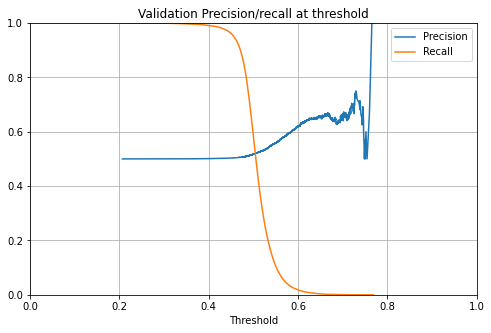

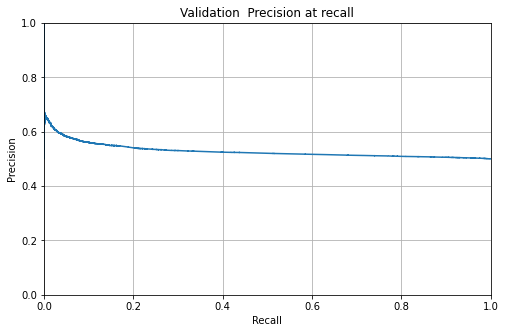

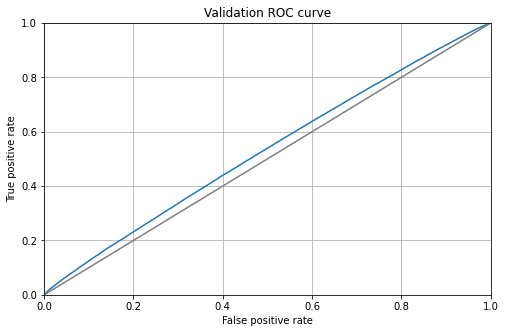

Validation AUC: 0.5297486438517569


In [5]:
probs = model.predict_proba(valid_X)
probs = probs[:, 1]

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(valid_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Validation Precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation  Precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(valid_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Validation ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Validation AUC: {roc_auc_score(valid_y, probs)}")

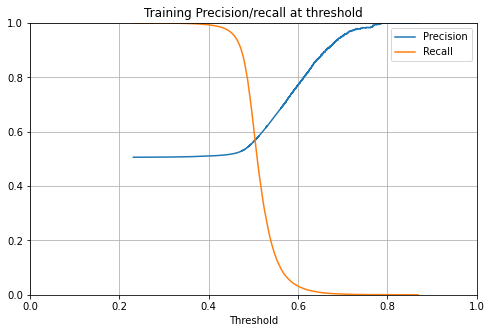

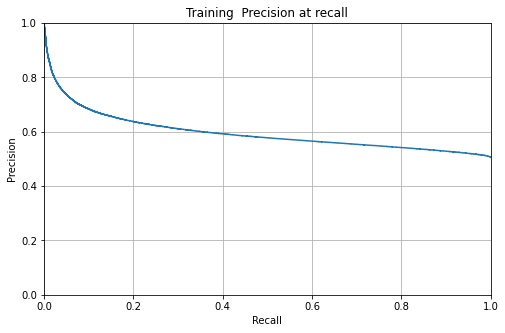

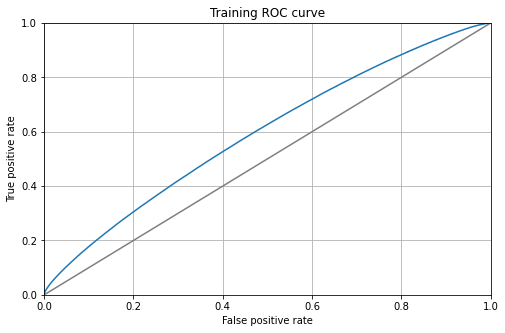

Training AUC: 0.5938762792257264


In [6]:
probs = model.predict_proba(train_X)
probs = probs[:, 1]

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(train_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Training Precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Training  Precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(train_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Training ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Training AUC: {roc_auc_score(train_y, probs)}")

In [7]:
# save model
joblib.dump(pp, "preprocessor.pkl")
model.save_model("model.xgb")